In [83]:
# Import Python Libraries used in this notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from datetime import datetime, timedelta

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from skforecast.model_selection import grid_search_forecaster

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

# Turn off Warnings
warnings.filterwarnings("ignore")

In [2]:
# Load Dataset
home_df = pd.read_csv('HomeC.csv')

# Drop last row which has bad data
home_df = home_df[:len(home_df)-1]

# Rename column to make it easier to work with
home_df.rename(columns={'Solar [kW]': 'Solar', }, inplace=True)

# Create a DateTime column from the current Unix time column
home_df['Datetime'] = pd.to_datetime(home_df['time'], unit='s', errors='coerce') - timedelta(hours=5)
home_df['Datetime'] = pd.date_range(start=home_df['Datetime'].min(), periods=len(home_df), freq='min')

# Backfill cloudCover data that is incorrectly filled with 'cloudCover'
home_df['cloudCover'].replace(['cloudCover'], method='bfill', inplace=True) 
home_df['cloudCover'] = home_df['cloudCover'].astype('float') 
home_df.head()

,time,use [kW],gen [kW],House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],...,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability,Datetime
0,1451624400,0.932833,0.003483,0.932833,0.000033,0.020700,0.061917,0.442633,0.124150,0.006983,...,Clear,29.26,1016.91,9.18,0.75,282.0,0.0,24.4,0.0,2016-01-01 00:00:00
1,1451624401,0.934333,0.003467,0.934333,0.000000,0.020717,0.063817,0.444067,0.124000,0.006983,...,Clear,29.26,1016.91,9.18,0.75,282.0,0.0,24.4,0.0,2016-01-01 00:01:00
2,1451624402,0.931817,0.003467,0.931817,0.000017,0.020700,0.062317,0.446067,0.123533,0.006983,...,Clear,29.26,1016.91,9.18,0.75,282.0,0.0,24.4,0.0,2016-01-01 00:02:00
3,1451624403,1.022050,0.003483,1.022050,0.000017,0.106900,0.068517,0.446583,0.123133,0.006983,...,Clear,29.26,1016.91,9.18,0.75,282.0,0.0,24.4,0.0,2016-01-01 00:03:00
4,1451624404,1.139400,0.003467,1.139400,0.000133,0.236933,0.063983,0.446533,0.122850,0.006850,...,Clear,29.26,1016.91,9.18,0.75,282.0,0.0,24.4,0.0,2016-01-01 00:04:00


In [53]:
# Select key columns for modeling based on previous data exploration
features = ['time', 'Datetime', 'Solar', 'temperature', 'visibility', 'cloudCover', 'windSpeed', 'humidity']
solar_df = home_df[features]

# Output Solar Dataframe
solar_df.head()


,time,Datetime,Solar,temperature,visibility,cloudCover,windSpeed,humidity
0,1451624400,2016-01-01 00:00:00,0.003483,36.14,10.0,0.75,9.18,0.62
1,1451624401,2016-01-01 00:01:00,0.003467,36.14,10.0,0.75,9.18,0.62
2,1451624402,2016-01-01 00:02:00,0.003467,36.14,10.0,0.75,9.18,0.62
3,1451624403,2016-01-01 00:03:00,0.003483,36.14,10.0,0.75,9.18,0.62
4,1451624404,2016-01-01 00:04:00,0.003467,36.14,10.0,0.75,9.18,0.62


In [76]:
hour_df = solar_df.groupby('Datetime')['Solar', 'temperature', 'visibility'].sum()
hour_df = hour_df.groupby(pd.Grouper(freq='60Min', label='right')).sum()
hour_df

,Solar,temperature,visibility
Datetime,,,
2016-01-01 01:00:00,0.198417,2167.86,600.00
2016-01-01 02:00:00,0.205300,2150.32,600.00
2016-01-01 03:00:00,0.206900,2123.10,600.00
2016-01-01 04:00:00,0.206850,2116.92,600.00
2016-01-01 05:00:00,0.206350,2127.10,600.00
...,...,...,...
2016-12-15 19:00:00,0.248250,2219.40,562.80
2016-12-15 20:00:00,0.246533,2255.05,531.32
2016-12-15 21:00:00,0.248483,2185.76,514.58


# Random Forest Regression Model

Train dates : 2016-01-01 01:00:00 --- 2016-09-19 11:00:00  (n=6299)
Test dates  : 2016-09-19 12:00:00 --- 2016-12-15 23:00:00  (n=2100)


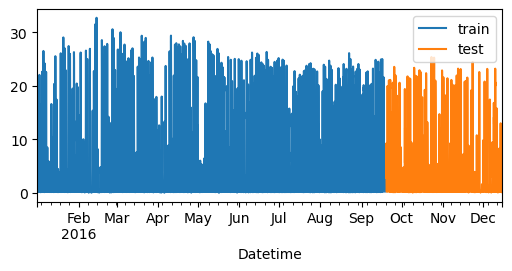

In [94]:
steps = round(len(hour_df) * .25)
data_train = hour_df[:-steps]
data_test = hour_df[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['Solar'].plot(ax=ax, label='train')
data_test['Solar'].plot(ax=ax, label='test')
ax.legend();

In [130]:
# Use SK Forecaster to perform multi-step forecasting
#  https://cienciadedatos.net/documentos/py27-time-series-forecasting-python-scikitlearn.html
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 12  # Previous hours of data to consider in model
             )

forecaster.fit(y=data_train['Solar'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
Transformer for y: None 
Transformer for exog: None 
Window size: 12 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2016-01-01 01:00:00'), Timestamp('2016-09-19 11:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: 60T 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2024-02-11 10:46:47 
Last fit date: 2024-02-11 10:46:57 
Skforecast version

Test error (MSE): 2.758874391187448


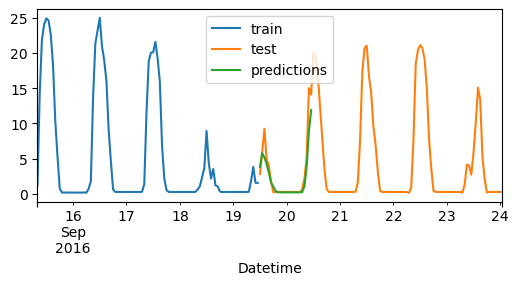

In [131]:
# Predict 24 Hours into the future
steps = 24
predictions = forecaster.predict(steps=steps)

# Plot predictions versus test data
fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['Solar'][-100:].plot(ax=ax, label='train')
data_test['Solar'][:110].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

# Calculate MSE
error_mse = mean_squared_error(
                y_true = data_test['Solar'][:steps],
                y_pred = predictions
            )

print(f"Test error (MSE): {error_mse}")


# LSTM Model

In [ ]:
# https://machinelearningmastery.com/how-to-develop-lstm-models-for-multi-step-time-series-forecasting-of-household-power-consumption/

